### Single-particle tracking pipeline for 2D data
Input: 
> Set of localizations, currently accepting ThunderStorm format
> 
Output:  
 >   1. Linked trajectories
  >  2. MSD analysis/graphs with trackpy
   > 3. Kinetic modeling of bound/free molecules with Spot-On
>

Dependencies:
> matplotlib, pandas, numpy \
> trackpy, noctiluca, bayesmsd

#### Load all packages

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt, pandas as pd, numpy as np     # all necessary

# Only need trackpy for tracking
import trackpy as tp
import bayesmsd
import noctiluca as nl

from scipy.optimize import curve_fit


C:\Users\ar138\AppData\Local\anaconda3\envs\chromtrack\lib\site-packages\bayesmsd\cython_imports.py:6: UserWarning: Did not find compiled code for gp.logL, falling back to python
  warn("Did not find compiled code for gp.logL, falling back to python")


#### Load localizations into dataframe

In [2]:
def load_locs(fn):
    locs = pd.read_csv(fn)
    locs = locs[["frame","x [nm]","y [nm]"]].rename(columns={"x [nm]": "x", "y [nm]": "y"}, errors = 'raise')

    conv_factor = 0.001
    locs = locs.mul({'frame':1,'x':conv_factor,'y':conv_factor})  # convert to um
    return locs

In [3]:
def track_and_filter(locs, search_range, memory, min_track):
    trajs = tp.link(locs, search_range, memory = memory, link_strategy = 'auto')      # trackpy links with the Crocker & Grier algorithm
    # Filter out spurious tracks
    tracks = tp.filter_stubs(trajs, min_track)  
    plt.figure()
    tp.plot_traj(tracks, mpp = 1)
    return tracks

In [4]:
fn_list = ['locs\\rx2\\cell8b_locs.csv','locs\\rx2\\cell8_locs.csv','locs\\rx2\\cell23_locs.csv','locs\\rx2\\cell12_locs.csv','locs\\rx2\\cell2_locs.csv','locs\\rx2\\cell20_locs.csv','locs\\rx2\\cell17_locs.csv','locs\\rx2\\cell6_locs.csv','locs\\rx2\\cell7_locs.csv','locs\\rx2\\cell15_locus1.csv','locs\\rx2\\cell15_locus2.csv','locs\\rx2\\cell15_locus3.csv']
#'locs\\rx2\\cell11.csv','locs\\rx2\\cell20_b.csv','locs\\rx2\\cell21.csv',

In [5]:
all_locs = pd.DataFrame()
for fn in fn_list:
    locs = load_locs(fn) 
    locs['x'] = locs['x'] + np.random.rand()*20
    all_locs= pd.concat([all_locs, locs], ignore_index=True)


Frame 1000: 2 trajectories present.


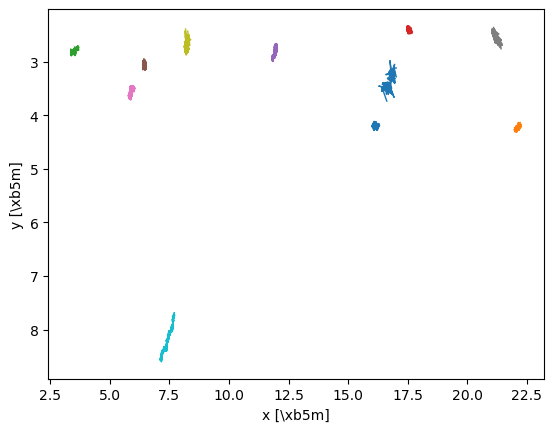

In [6]:
all_tracks = track_and_filter(all_locs, 0.5, 3,150)

In [10]:
all_tracks.index.names = ['Track number']
all_tracks.head()

,frame,x,y
Track number,,,
0,1,16.149283,4.196172
1,1,22.199170,4.224527
4,1,3.394931,2.856005
5,1,17.618832,2.438179
10,1,11.948805,2.679949


In [11]:
all_tracks.to_csv('all_tracks.csv')

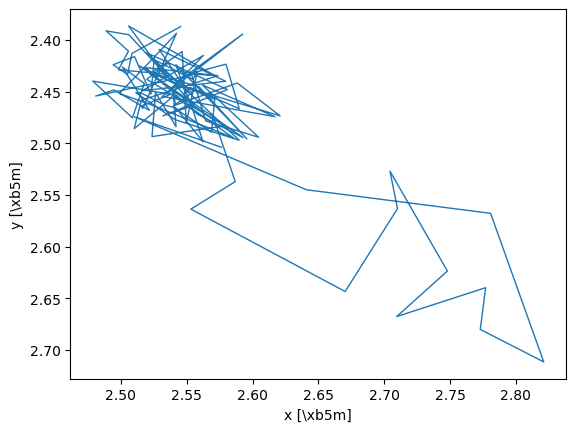

<Axes: xlabel='x [\\xb5m]', ylabel='y [\\xb5m]'>

In [45]:
tp.plot_traj(all_tracks[all_tracks['particle'] == 81], mpp = 1)


####  __Plot the individual MSDs of all the trajectories in the dataset__ 


In [7]:
def calc_imsds(tracks, mpp, fps, maxlag, fn):
    im = tp.imsd(tracks, mpp, fps, max_lagtime = maxlag)
    fig, ax = plt.subplots()
    ax.plot(im.index, im, 'k-', alpha=0.3)  # black lines, semitransparent
    ax.set(ylabel=r'MSD [$\mu$m$^2$]',
           xlabel='lag time $t (s)$')
    ax.set_yscale('linear')
    ax.set_xscale('linear')
    ax.set_ylabel('MSD (um^2)')
    ax.set_title('iMSDs')
    #ax.set_ylim([0, 0.0075])
    ax.set_xticks([0.1, 0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
    #ax.set_xscale('log')
    #ax.set_yscale('log')
    plt.savefig(fn)
    return im

In [10]:
ims = ims[[0,1,4,5,10,13,14,135,156,263,420]]

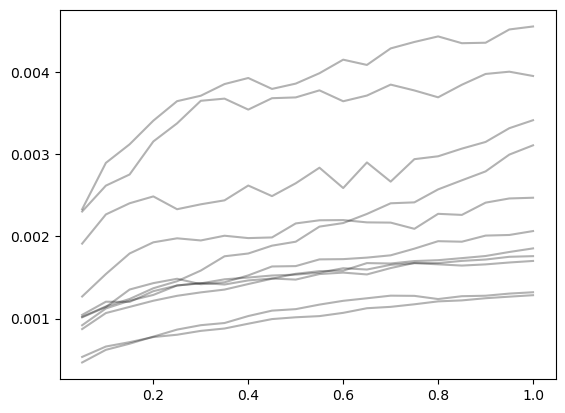

In [12]:
plt.plot(ims.index, ims, 'k-', alpha=0.3)  # black lines, semitransparent

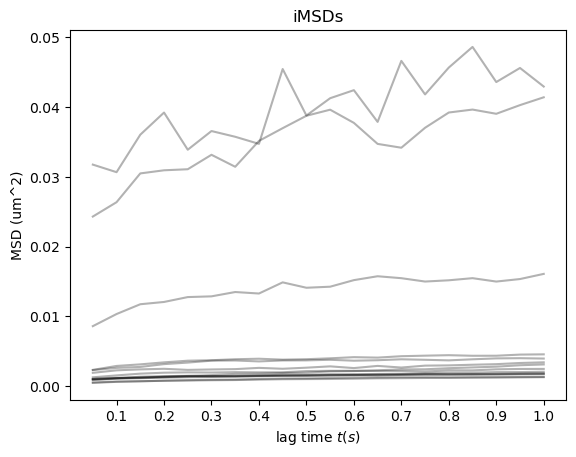

In [8]:
ims = calc_imsds(all_tracks, 1, 20, 20, 'RUNX2_iMSDs_20Hz_new.png')

In [1]:
def backlund_msd_2D_log(lag, D_eff,  alpha, sigma):
    t_exp = 0.05
    return np.log((((4*D_eff*np.power(t_exp,alpha))*(np.power(lag+1,alpha+2) + 
                                            np.power(lag-1,alpha+2) -
                                            2*np.power(lag,alpha+2)))/((alpha+2)*(alpha+1))) -
                                            (8*D_eff*np.power(t_exp,alpha)/((alpha+2)*(alpha+1))) +
                                            2*np.power(sigma,2))

In [10]:
def backlund_msd_2D(lag, D_eff,  alpha, sigma):
    t_exp = 0.05
    return ((((4*D_eff*np.power(t_exp,alpha))*(np.power(lag+1,alpha+2) + 
                                            np.power(lag-1,alpha+2) -
                                            2*np.power(lag,alpha+2)))/((alpha+2)*(alpha+1))) -
                                            (8*D_eff*np.power(t_exp,alpha)/((alpha+2)*(alpha+1))) +
                                            2*np.power(sigma,2))

In [11]:
def msd_2D_log(lag, D_eff,  alpha, sigma):
    t_exp = 0.05
    return np.log((4*D_eff*np.power(lag*t_exp,alpha)) + 2*np.power(sigma,2))

In [19]:
from matplotlib.lines import Line2D
import warnings
def fit_imsds(im, t_exp, fn):
    fits = pd.DataFrame()
    fits.index = im.index
    xdata = im.index.to_numpy() / t_exp
    bounds=([0.00001, 0.01, 0.001], [0.01, 2., 0.1])
    p0 = [0.0001,0.5,0.001]
    #im.columns = ['Locus 1', 'Locus 2', 'Locus 3', 'Locus 4', 'Locus 5']
    params = pd.DataFrame()
    #params.columns = im.columns
    params.index = ['D_eff', 'alpha', 'sigma']
    for i in im.columns:   
        popt, pcov = curve_fit(msd_2D_log, xdata, np.log(im[i].to_numpy()), bounds=bounds, p0 = p0, maxfev=5000)
        fits['Fit of ' + str(i)] = msd_2D(xdata,*popt)
        params[i] = popt

    ax = im.plot(style = 'k-',alpha = 0.2, linewidth = 2)
    warnings.filterwarnings('ignore')
    fits.plot(ax=ax,style = 'k--',alpha = 0.6, linewidth = 2)
    warnings.filterwarnings('ignore')
    plt.yscale('linear')
    plt.xscale('linear')
    plt.ylabel('MSD (um^2)')
    plt.title('Fit to 2D MSD')
    #plt.ylim([0, 0.0075])
    ax.set_xticks([0.1, 0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
    lined = Line2D([0], [0], label='Data', color='k', linestyle = '-')
    linef = Line2D([0], [0], label='Fit', color='k', linestyle = '--')
    plt.legend(handles=[lined, linef])
    plt.savefig(fn)
    return params

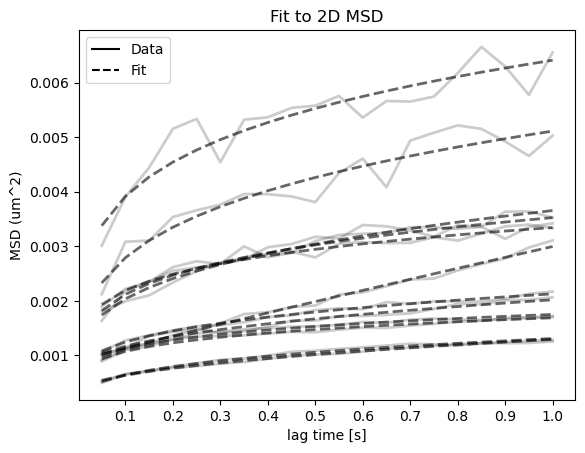

In [83]:
params = fit_imsds(ims,0.05,'tester_1106.png')

In [71]:
params

,1,2,5,8,10,11,179,424,1213
D_eff,0.000417,0.000784,0.000440,0.000338,0.000244,0.000651,0.000525,0.001602,0.000257
alpha,0.213683,0.156859,0.302642,0.430706,0.496658,0.612265,0.943975,0.213968,0.430960
sigma,0.001000,0.001000,0.013593,0.018285,0.012707,0.029035,0.021147,0.001000,0.020341


In [84]:
params.mean(axis=1)

D_eff    0.000676
alpha    0.338063
sigma    0.007374
dtype: float64

In [85]:
params.std(axis=1)

D_eff    0.000418
alpha    0.212849
sigma    0.008157
dtype: float64

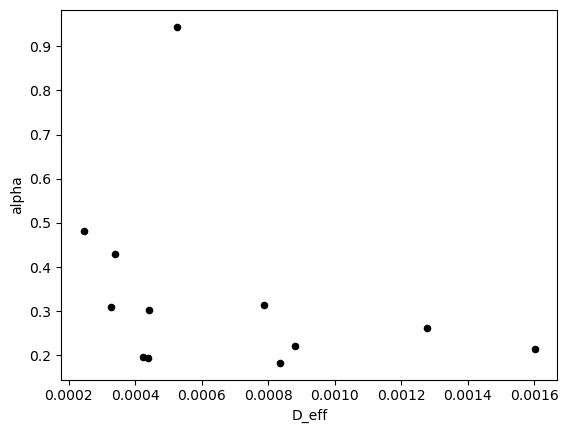

In [82]:
params.transpose().plot.scatter('D_eff','alpha', c = 'k')
plt.xscale('linear')
plt.savefig('dist.png')
#plt.yscale('log')

#### __Create noctiluca TaggedSet of trajectories for further analysis__

In [ ]:


def backlund_msd_1D(lag, D_eff,  alpha, sigma):
    t_exp = 0.05
    return ((((2*D_eff*np.power(t_exp,alpha))*(np.power(lag+1,alpha+2) + 
                                            np.power(lag-1,alpha+2) -
                                            2*np.power(lag,alpha+2)))/((alpha+2)*(alpha+1))) -
                                            (4*D_eff*np.power(t_exp,alpha)/((alpha+2)*(alpha+1))) +
                                            2*np.power(sigma,2))

In [12]:
def msd_2D(lag, D_eff,  alpha, sigma):
    t_exp = 0.05
    return ((4*D_eff*np.power(lag*t_exp,alpha)) + 2*np.power(sigma,2))

In [ ]:
def power_law(lag, D, alpha, sigma):
    return D*np.power(lag,alpha) + np.power(sigma,2)

In [ ]:
t_exp = 0.05
xdata = im.index.to_numpy() / t_exp
ydata = im[5].to_numpy() 

popt, pcov = curve_fit(backlund_msd_1D, xdata, ydata, bounds=(0, [0.1, 2., 0.1]), p0 = [0.0001,0.5,0.001],maxfev=5000)

plt.plot(xdata, backlund_msd_1D(xdata, *popt), 'g--')
plt.plot(xdata,ydata)
plt.yscale('log')
plt.xscale('log')
display(popt)

In [ ]:
from matplotlib.lines import Line2D
import warnings
fits = pd.DataFrame()
fits.index = im.index
xdata = im.index.to_numpy() / t_exp
bounds=(0, [0.1, 2., 0.1])
p0 = [0.0001,0.5,0.001]
im.columns = ['Locus 1', 'Locus 2', 'Locus 3', 'Locus 4', 'Locus 5']
params = pd.DataFrame()
#params.columns = im.columns
params.index = ['D_eff', 'alpha', 'sigma']
for i in im.columns:   
    popt, pcov = curve_fit(backlund_msd_1D, xdata, im[i].to_numpy(), bounds=bounds, p0 = p0, maxfev=5000)
    fits['Fit of ' + i] = backlund_msd_1D(xdata,*popt)
    params[i] = popt

ax = im.plot(style = ['b','g','r','c','m'])
warnings.filterwarnings('ignore')
fits.plot(ax=ax,style = ['b--','g--','r--','c--','m--'])
warnings.filterwarnings('ignore')
plt.yscale('linear')
plt.xscale('linear')
plt.ylabel('MSD (um^2)')
plt.title('Fit to 1D MSD')
ax.set_xticks([0.1, 0.2,0.3,0.4,0.5,0.6])
lined = Line2D([0], [0], label='Data', color='k', linestyle = '-')
linef = Line2D([0], [0], label='Fit', color='k', linestyle = '--')
plt.legend(handles=[lined, linef])
plt.savefig('RUNX2 P2 MSD_1D Fits')

In [ ]:
params

In [ ]:
from matplotlib.lines import Line2D
import warnings
fits = pd.DataFrame()
fits.index = im.index
xdata = im.index.to_numpy() / t_exp
bounds=(0, [0.1, 2., 0.1])
p0 = [0.0001,0.5,0.001]
im.columns = ['Locus 1', 'Locus 2', 'Locus 3', 'Locus 4', 'Locus 5']
params = pd.DataFrame()
#params.columns = im.columns
params.index = ['D_eff', 'alpha', 'sigma']
for i in im.columns:   
    popt, pcov = curve_fit(backlund_msd_2D, xdata, im[i].to_numpy(), bounds=bounds, p0 = p0, maxfev=5000)
    fits['Fit of ' + i] = backlund_msd_2D(xdata,*popt)
    params[i] = popt

ax = im.plot(style = ['b','g','r','c','m'])
warnings.filterwarnings('ignore')
fits.plot(ax=ax,style = ['b--','g--','r--','c--','m--'])
warnings.filterwarnings('ignore')
plt.yscale('linear')
plt.xscale('linear')
plt.ylabel('MSD (um^2)')
plt.title('Fit to 2D MSD')
ax.set_xticks([0.1, 0.2,0.3,0.4,0.5,0.6])
lined = Line2D([0], [0], label='Data', color='k', linestyle = '-')
linef = Line2D([0], [0], label='Fit', color='k', linestyle = '--')
plt.legend(handles=[lined, linef])
plt.savefig('RUNX2 P2 MSD_2D Fits')

In [ ]:
params

In [ ]:
from matplotlib.lines import Line2D
import warnings
fits = pd.DataFrame()
fits.index = im.index
xdata = im.index.to_numpy() / t_exp
bounds=(0, [0.1, 2., 0.1])
p0 = [0.0001,0.5,0.001]
im.columns = ['Locus 1', 'Locus 2', 'Locus 3', 'Locus 4', 'Locus 5']
params = pd.DataFrame()
#params.columns = im.columns
params.index = ['D_eff', 'alpha', 'sigma']
for i in im.columns:   
    popt, pcov = curve_fit(backlund_msd_2D_log, xdata, np.log(im[i].to_numpy()), bounds=bounds, p0 = p0, maxfev=5000)
    fits['Fit of ' + i] = backlund_msd_2D(xdata,*popt)
    params[i] = popt

ax = im.plot(style = ['b','g','r','c','m'])
warnings.filterwarnings('ignore')
fits.plot(ax=ax,style = ['b--','g--','r--','c--','m--'])
warnings.filterwarnings('ignore')
plt.yscale('linear')
plt.xscale('linear')
plt.ylabel('MSD (um^2)')
plt.title('Fit to 2D MSD')
ax.set_xticks([0.1, 0.2,0.3,0.4,0.5,0.6])
lined = Line2D([0], [0], label='Data', color='k', linestyle = '-')
linef = Line2D([0], [0], label='Fit', color='k', linestyle = '--')
plt.legend(handles=[lined, linef])
plt.savefig('RUNX2 P2 BL_MSD_2D_Log Fits')

In [ ]:
params

In [ ]:
from matplotlib.lines import Line2D
import warnings
fits = pd.DataFrame()
fits.index = im.index
xdata = im.index.to_numpy() / t_exp
bounds=([0.00001, 0.001, 0.001], [0.1, 2., 0.1])
p0 = [0.0001,0.5,0.001]
im.columns = ['Locus 1', 'Locus 2', 'Locus 3', 'Locus 4', 'Locus 5']
params = pd.DataFrame()
#params.columns = im.columns
params.index = ['D_eff', 'alpha', 'sigma']
for i in im.columns:   
    popt, pcov = curve_fit(msd_2D_log, xdata, np.log(im[i].to_numpy()), bounds=bounds, p0 = p0, maxfev=5000)
    fits['Fit of ' + i] = msd_2D(xdata,*popt)
    params[i] = popt

ax = im.plot(style = ['b','g','r','c','m'])
warnings.filterwarnings('ignore')
fits.plot(ax=ax,style = ['b--','g--','r--','c--','m--'])
warnings.filterwarnings('ignore')
plt.yscale('linear')
plt.xscale('linear')
plt.ylabel('MSD (um^2)')
plt.title('Fit to 2D MSD')
ax.set_xticks([0.1, 0.2,0.3,0.4,0.5,0.6])
lined = Line2D([0], [0], label='Data', color='k', linestyle = '-')
linef = Line2D([0], [0], label='Fit', color='k', linestyle = '--')
plt.legend(handles=[lined, linef])
plt.savefig('RUNX2 P2 MSD_2D_Log Fits')

In [ ]:
params

In [ ]:
plt.violinplot(params.loc['D_eff'])

In [ ]:
data = nl.TaggedSet()
for i in sorted(tm['particle'].unique()):
    data.add(nl.make_Trajectory(tracks.loc[tracks['particle'] == i], t_column = 'frame',pos_columns = ['x','y']))
nl.plot.msd_overview(data,color='tab:blue', alpha=0.2)
plt.xlabel('time [frames]')
plt.ylabel('MSD [$\mu$m$^2$]')
plt.ylim([0.0001, None])
plt.title('Single trajectory & ensemble MSDs')
#plt.show()
plt.savefig('RUNX2 Mean')

In [ ]:
data2 = nl.TaggedSet()
for traj in data:
    if len(traj) > 75:
        data2.add(nl.make_Trajectory(traj[0:75]))
    else:
        data2.add(nl.make_Trajectory(traj))

data = data2

#### Compare TA-MSD to eMSD

In [ ]:
msd_data = nl.analysis.MSD(data, recalculate = True)
e_msd = nl.analysis.MSD(data, TA=False, recalculate=True)

plt.loglog(e_msd, label='eMSD')
plt.loglog(msd_data, label='TA-MSD') # this was calculated above

#nl.plot.msd_overview(data,color='tab:blue', alpha=0.2)
plt.xlabel('time [frames]')
plt.ylabel('MSD [$\mu$m$^2$]')
plt.ylim([0.000001, None])
plt.title('Single trajectory & ensemble MSDs')
plt.show()
#plt.legend()

#### __Bayesian MSD fitting__

In [ ]:
fit = bayesmsd.lib.NPXFit(data, ss_order=1)
for name in fit.parameters:
    print(name)
#fit.parameters['log(σ²) (dim 0)'].fix_to = 2 # data is synthetic, so
#fit.parameters['log(σ²) (dim 1)'].fix_to = 2 # no localization error

fitres = fit.run(show_progress=True)

print(f"error x: {np.exp(fitres['params']['log(σ²) (dim 0)']):.7f}")
print(f"error y: {np.exp(fitres['params']['log(σ²) (dim 1)']):.7f}")
print(f"fitted exponent:  {       fitres['params'][     'α (dim 0)'] :.7f}")
print(f"fitted prefactor: {np.exp(fitres['params']['log(Γ) (dim 0)']):.7f}")


In [ ]:
fig = plt.figure()
nl.analysis.MSD(data, recalculate = True)
nl.plot.msd_overview(data,color='tab:blue', alpha=0.1)
# Now add the fitted MSD
msd = fit.MSD(fitres['params']) # `msd` is now a callable function representing MSD(Δt)
dt = np.logspace(0, 2)
plt.plot(dt, msd(dt),color='r', linewidth=3,label='fitted MSD',)
plt.legend()

plt.xlabel('lag time [frames]')
plt.ylabel('MSD [$\mu$m$^2$]')
#plt.show()
plt.savefig('RUNX2 P2 fitted MSD')

In [ ]:
from saspt import sample_detections, StateArray, RBME
detections = tm.rename(columns  = {'particle':'trajectory'})
detections.index.name = None
detections.index = range(1, len(detections)+1)
print(detections)

settings = dict(
    likelihood_type = RBME,
    pixel_size_um = 1,
    frame_interval = 0.02,
    focal_depth = 0.7,
    progress_bar = True,
)

In [ ]:
SA = StateArray.from_detections(detections, **settings)

In [ ]:
SA.plot_occupations("rbme_occupations_runx2.png")
plt.show()